# Fig 1-2

We have run the *Monod* inference pipeline on six pre-clustered mouse brain cell glutamatergic subtypes, as well as the entire glutamatergic cell type. In this notebook, we analyze whether the amount of biological variation between the subtypes concords with the amount of biological variation predicted by normalization and mechanistic fit procedures.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()


In [2]:
import sys
sys.path.insert(0, '/home/ggorin/projects/monod/src/')

In [3]:
import monod
from monod import analysis
import numpy as np
import matplotlib.pyplot as plt
import anndata
import pandas as pd
import scanpy as sc

In [4]:
dir_string = './fits/gg_230328_026_allen_celltypes_1'

## data import

In [5]:
sample = 'B08'

In [6]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')


In [7]:
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_membership = pd.concat((allen_membership,
                              allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)),
                              axis=1)


In [8]:
allen_membership = allen_membership[allen_membership['sample'] == sample]

In [9]:
allen_membership

,barcode,cluster_id,cell_barcode,sample,cluster_label,subclass_label,class_label
66697,AAACCCAAGTACGAGC-10L8TX_190430_01_B08,93,AAACCCAAGTACGAGC,B08,Vip Chat_low,Low Quality,Low Quality
66698,AAACCCAAGTGAACAT-10L8TX_190430_01_B08,42,AAACCCAAGTGAACAT,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
66699,AAACCCAAGTTGAATG-10L8TX_190430_01_B08,40,AAACCCAAGTTGAATG,B08,L2/3 IT,L2/3 IT,Glutamatergic
66700,AAACCCACACCCTAGG-10L8TX_190430_01_B08,100,AAACCCACACCCTAGG,B08,Sst Myh8_3_low,Low Quality,Low Quality
66701,AAACCCACACGATAGG-10L8TX_190430_01_B08,42,AAACCCACACGATAGG,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
...,...,...,...,...,...,...,...
75116,TTTGTTGAGGGTTAAT-10L8TX_190430_01_B08,140,TTTGTTGAGGGTTAAT,B08,L6 NP Trh_low,Low Quality,Low Quality
75117,TTTGTTGCAAAGGATT-10L8TX_190430_01_B08,24,TTTGTTGCAAAGGATT,B08,Sst Myh8_1,Sst,GABAergic
75118,TTTGTTGGTGAGGAAA-10L8TX_190430_01_B08,28,TTTGTTGGTGAGGAAA,B08,Sst Hpse_3,Sst,GABAergic
75119,TTTGTTGTCCAAACCA-10L8TX_190430_01_B08,40,TTTGTTGTCCAAACCA,B08,L2/3 IT,L2/3 IT,Glutamatergic


In [10]:
raw_file = '/home/ggorin/count_data/loom_allen_kb/allen_'+sample+'_raw.loom'
ad = sc.read_loom(raw_file)

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
ad = ad[ad.obs['barcode'].isin(allen_membership['cell_barcode'])]
ad.obs['total_cell_size'] = (ad.layers['spliced'].sum(1) + ad.layers['unspliced'].sum(1))
ad = ad[(ad.obs['total_cell_size'] > 1e4)]

/tmp/ipykernel_1929807/1577410883.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['total_cell_size'] = (ad.layers['spliced'].sum(1) + ad.layers['unspliced'].sum(1))


In [12]:
# ad

In [13]:
obs_df = ad.obs

In [14]:
obs_df=obs_df.merge(allen_membership,left_on='barcode',right_on='cell_barcode').drop(['barcode_x','barcode_y'],axis=1)

In [40]:
ad.obs=obs_df

/home/ggorin/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [41]:
ad.obs = ad.obs.set_index('cell_barcode')

In [42]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label
cell_barcode,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic


In [43]:
sd_string = dir_string+'/allen_B08_Glutamatergic/raw.sd'
sd = monod.analysis.load_search_data(sd_string)

In [44]:
# sd.gene_names.astype(str)

In [45]:
# ad.var

In [46]:
ad.var = ad.var.set_index('gene_name').astype(str)

KeyError: "None of ['gene_name'] are in the columns"

In [47]:
# ad.var.index.isin(sd.gene_names)

In [48]:
ad.var.index

Index(['AC149090.1', 'Ncstn', 'Brinp2', 'Cacna1e', 'Cadm3', 'Ncoa2', 'Arpc2',
       'Fhl2', 'Hdac4', 'Kansl3',
       ...
       'Sms', 'Lrch2', 'Rnf128', 'Arhgef9', 'Apoo', 'Dmd', 'Chic1', 'Kantr',
       '5330434G04Rik', 'Gm47283'],
      dtype='object', name='gene_name', length=2951)

In [49]:
# sd.gene_names

In [50]:
ad = ad[:,ad.var.index.isin(sd.gene_names)]

In [51]:
ad

View of AnnData object with n_obs × n_vars = 7808 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced'

In [52]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label
cell_barcode,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic


In [53]:
ad.obs['sum_spliced_counts_filtered'] = ad.layers['spliced'].sum(1)

/tmp/ipykernel_1929807/3803360763.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['sum_spliced_counts_filtered'] = ad.layers['spliced'].sum(1)


In [54]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label,sum_spliced_counts_filtered
cell_barcode,,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12754.0
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,8521.0
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality,3433.0
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12358.0
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,10373.0
...,...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,9423.0
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic,8011.0
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic,12612.0


In [55]:
# C_S = np.array(ad.layers['spliced'].sum(1)).squeeze()

In [56]:
# C_S.shape

In [57]:
# C_S.shape

In [58]:
# ad.layers['spliced'].sum(1)

In [262]:
# ad.layers['spliced']/(ad.layers['spliced'].sum(0)[:,None])*C_S

In [63]:
ad.layers['spliced_PF'] = (ad.layers['spliced'].toarray()/np.array(ad.obs['sum_spliced_counts_filtered'])[:,None]*C_S.mean())

In [64]:
ad.layers['spliced_log'] = np.log(ad.layers['spliced_PF'] + 1)

In [65]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
# pca_transformer.fit(S_log.T)
# S_PCA_50D = pca_transformer.transform(S_log.T).T
# S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [66]:
pca_transformer.fit(ad.layers['spliced_log'])

PCA(n_components=50)

In [67]:
S_PCA_50D = pca_transformer.transform(ad.layers['spliced_log'])

In [68]:
S_PCA = pca_transformer.inverse_transform(S_PCA_50D)

In [69]:
ad.layers['spliced_PCA'] = S_PCA

In [70]:
import umap
umap_transformer = umap.UMAP()


In [71]:
umap_transformer.fit(S_PCA_50D)


UMAP(dens_frac=0.0, dens_lambda=0.0)

In [72]:
S_UMAP_2D = umap_transformer.transform(S_PCA_50D)


In [73]:
# S_UMAP_2D.shape

In [74]:
S_UMAP_50D = umap_transformer.inverse_transform(S_UMAP_2D)

In [75]:
S_UMAP = pca_transformer.inverse_transform(S_UMAP_50D)

In [76]:
ad.layers['spliced_UMAP'] = S_UMAP

In [77]:
ad.obs

,total_cell_size,cluster_id,sample,cluster_label,subclass_label,class_label,sum_spliced_counts_filtered
cell_barcode,,,,,,,
AAACCCAAGTGAACAT,59975.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12754.0
AAACCCAAGTTGAATG,39702.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,8521.0
AAACCCACACCCTAGG,47228.0,100,B08,Sst Myh8_3_low,Low Quality,Low Quality,3433.0
AAACCCACACGATAGG,66171.0,42,B08,L5 IT Tcap_2,L5 IT,Glutamatergic,12358.0
AAACCCACAGAGGGTT,41720.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,10373.0
...,...,...,...,...,...,...,...
TTTGTTGAGGGCCAAT,36294.0,40,B08,L2/3 IT,L2/3 IT,Glutamatergic,9423.0
TTTGTTGCAAAGGATT,37335.0,24,B08,Sst Myh8_1,Sst,GABAergic,8011.0
TTTGTTGGTGAGGAAA,58223.0,28,B08,Sst Hpse_3,Sst,GABAergic,12612.0


In [78]:
# plt.scatter(S_UMAP_2D[:,0],S_UMAP_2D[:,1],c=list(ad.obs['cluster_id'].astype('category')))

## blah

In [79]:
sd.layers.shape

(2, 2951, 5343)

In [80]:
ad.layers['spliced']

<7808x2951 sparse matrix of type '<class 'numpy.float32'>'
	with 15752115 stored elements in Compressed Sparse Row format>

In [81]:
subclasses_to_include = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subclasses_to_exclude = ['L6 IT Car3','L5 ET']
class_to_consider='Glutamatergic'

In [82]:
ad_subset = ad[(ad.obs['class_label']==class_to_consider) & 
              (ad.obs['subclass_label'].isin(subclasses_to_include))]

In [83]:
ad_subset

View of AnnData object with n_obs × n_vars = 5343 × 2951
    obs: 'total_cell_size', 'cluster_id', 'sample', 'cluster_label', 'subclass_label', 'class_label', 'sum_spliced_counts_filtered'
    var: 'gene_id'
    layers: 'matrix', 'spliced', 'unspliced', 'spliced_PF', 'spliced_log', 'spliced_PCA', 'spliced_UMAP'

In [84]:
ad_subset.obs['subclass_label'].value_counts()

L5 IT      2382
L6 CT      1333
L2/3 IT     823
L6 IT       489
L5/6 NP     250
L6b          66
Name: subclass_label, dtype: int64

In [85]:
ad_subset.layers['spliced'] = ad_subset.layers['spliced'].toarray()

In [86]:
def get_cv2(ad_,layer):
    return ad_.layers[layer].var(0)/ad_.layers[layer].mean(0)**2
    
cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP = [get_cv2(ad_subset,x) 
                                           for x in ['spliced','spliced_PF','spliced_log','spliced_PCA','spliced_UMAP']]

In [87]:
cv2s = np.asarray([cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP])

In [88]:
total_mean = ad_subset.layers['spliced'].mean(0)
q = np.quantile(total_mean,0.95)
gf = total_mean<q

In [89]:
# gf.sum()

Text(0.5, 1.0, 'CV2')

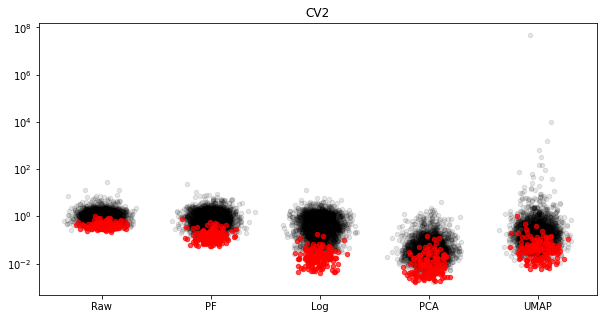

In [90]:
n_genes = len(ad_subset.var)
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2s[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2s[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'])
ax1.set_title('CV2')


In [91]:
cv2_fracs = np.array([cv2s[i]/cv2s[0] for i in range(1,5)])

Text(0.5, 1.0, 'CV2 fractions')

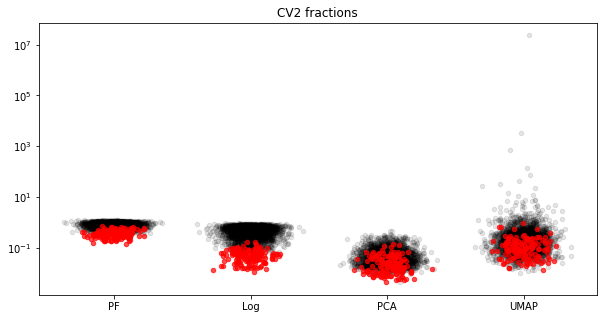

In [92]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(4):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2_fracs[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2_fracs[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(4),['PF','Log','PCA','UMAP'])
ax1.set_title('CV2 fractions')


In [93]:
total_mean = ad_subset.layers['spliced'].mean(0)
total_variance = ad_subset.layers['spliced'].var(0)


In [94]:
subclass_abundances = []
subclass_means = []
for subclass in subclasses_to_include:
    subclass_mean = ad_subset[ad_subset.obs['subclass_label']==subclass].layers['spliced'].mean(0)
    subclass_means.append(subclass_mean)
    subclass_abundances.append((ad_subset.obs['subclass_label']==subclass).mean())
subclass_abundances = np.asarray(subclass_abundances)
subclass_means = np.asarray(subclass_means)
baseline = (((subclass_means-total_mean[None,:])**2) * subclass_abundances[:,None]).sum(0) / total_variance

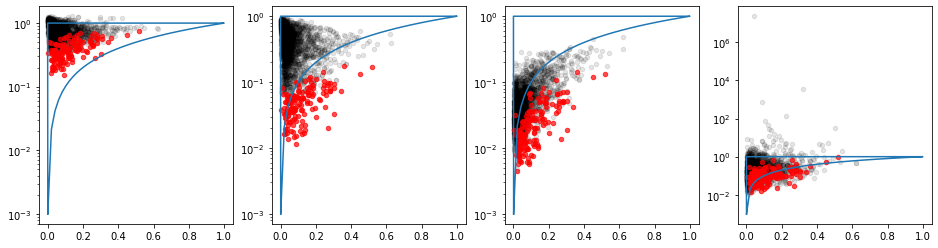

In [196]:
fig1,ax1=plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax1[i].scatter(baseline[gf],cv2_fracs[i,gf],20,'k',alpha=0.1)
    ax1[i].scatter(baseline[~gf],cv2_fracs[i,~gf],20,'r',alpha=0.7)
    ax1[i].set_yscale('log')
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[i].plot(region_x,region_y)
#     ax1[i].set_ylim([cv2_fracs[i].min()*0.9,cv2_fracs[i].max()*1.1])


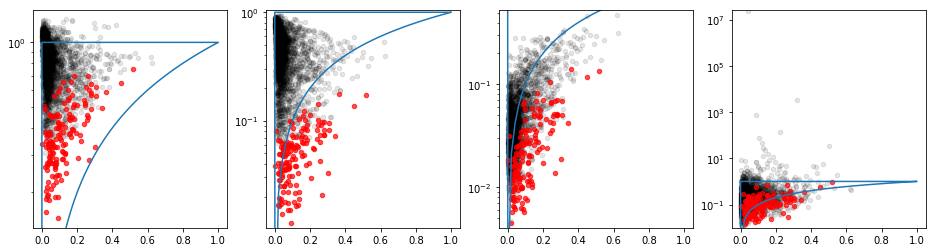

In [197]:
fig1,ax1=plt.subplots(1,4,figsize=(16,4))
for i in range(4):
    ax1[i].scatter(baseline[gf],cv2_fracs[i,gf],20,'k',alpha=0.1)
    ax1[i].scatter(baseline[~gf],cv2_fracs[i,~gf],20,'r',alpha=0.7)
    ax1[i].set_yscale('log')
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[i].plot(region_x,region_y)
    ax1[i].set_ylim([cv2_fracs[i].min()*0.9,cv2_fracs[i].max()*1.1])


Surprisingly, doing the analysis on the entire dataset works out the same

In [152]:
g1 = 'Slc17a5'
g2 = 'Slc6a7'

In [153]:
g1 in ad_subset.var.index

True

In [154]:
sorted_genes = np.argsort(cv2_fracs[3])
maxind = sorted_genes[-1]


In [155]:
ad_subset.var.index[maxind]

'Slc6a7'

In [156]:
cv2_fracs[3]


array([0.05841911, 0.15146416, 0.16269645, ..., 0.18214162, 0.67344356,
       0.13902824], dtype=float32)

In [157]:
colors = ['wheat','cornflowerblue','aquamarine','lightgray','lightcoral','palegreen']
colors = {x:color for x,color in zip(ad_subset.obs['subclass_label'].value_counts().index,colors)}

In [158]:
cell_colors = [colors[x] for x in ad_subset.obs['subclass_label']]

In [159]:
# [x for x in ad_subset.var.index if 'Slc' in x]

In [160]:
# ad_subset[:,'Snap25']

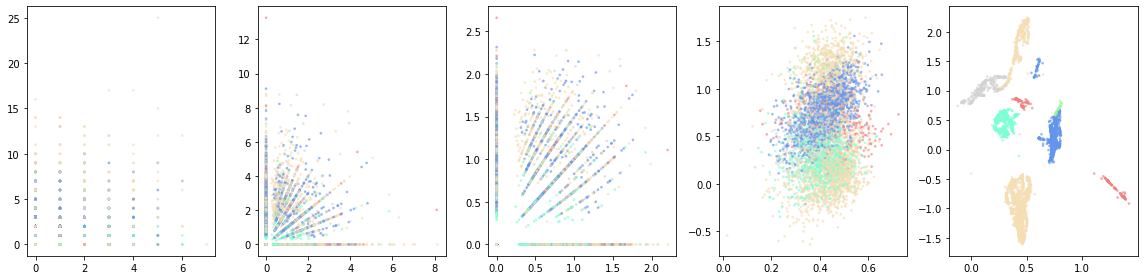

In [175]:
layers = ['spliced','spliced_PF','spliced_log','spliced_PCA','spliced_UMAP']
# subclasses_to_plot = ['L5 IT','L6 CT']
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

for i in range(5):
    x = ad_subset[:,g1].layers[layers[i]]
    y = ad_subset[:,g2].layers[layers[i]]
    ax1[i].scatter(x,y,s=3,c=cell_colors,alpha=0.5)
fig1.tight_layout()

In [166]:
gi1  = ad_subset.var.index==g2
print(subclass_means[:,gi1])
print(cv2s[:,gi1])
print(cv2_fracs[:,gi1])

[[0.6038882]
 [1.5667506]
 [1.6646217]
 [1.16     ]
 [1.8469617]
 [2.9848485]]
[[2.0170162e+00]
 [1.6279398e+00]
 [1.0892419e+00]
 [5.7149547e-01]
 [4.6334772e+07]]
[[8.0710304e-01]
 [5.4002637e-01]
 [2.8333709e-01]
 [2.2971938e+07]]


Well... the case to make about zero-centering is very hard indeed.

In [174]:
y.mean()

ArrayView(-0.00014225, dtype=float32)

In [173]:
y.var()

ArrayView(0.93770254, dtype=float32)

In [146]:
ad_subset[:,'Slc17a5'].layers['spliced'].tod

array([[1.],
       [0.],
       [1.],
       ...,
       [1.],
       [2.],
       [2.]], dtype=float32)

## Something completely different

What about fraction of variance due to cell type differences?

In [188]:
def get_var_fraction_due_to_cts(ad_,layer,subclasses):
    total_variance = ad_.layers[layer].var(0)
    total_mean = ad_.layers[layer].mean(0)
    subclass_means = []
    subclass_abundances = []
    for subclass in subclasses:
        subclass_mean = ad_subset[ad_.obs['subclass_label']==subclass].layers[layer].mean(0)
        subclass_means.append(subclass_mean)
        subclass_abundances.append((ad_.obs['subclass_label']==subclass).mean())
    subclass_abundances = np.asarray(subclass_abundances)
    subclass_means = np.asarray(subclass_means)
    variance_due_to_means = (((subclass_means-total_mean[None,:])**2) * subclass_abundances[:,None]).sum(0) 
    return variance_due_to_means / total_variance
#     return ad_.layers[layer].var(0)/ad_.layers[layer].mean(0)**2
    


In [203]:
var_frac_raw,var_frac_PF,var_frac_log,var_frac_PCA,var_frac_UMAP = [
    get_var_fraction_due_to_cts(ad_subset,x,subclasses_to_include) 
                                           for x in ['spliced','spliced_PF','spliced_log','spliced_PCA','spliced_UMAP']]
var_fracs = np.asarray([var_frac_raw,var_frac_PF,var_frac_log,var_frac_PCA,var_frac_UMAP])

Text(0, 0.5, 'Fraction of variance due to cell type mean differences')

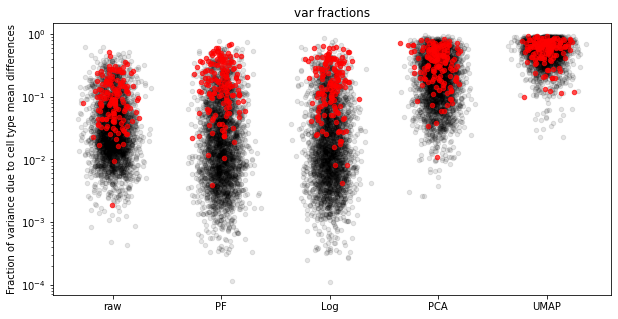

In [193]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],var_fracs[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],var_fracs[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['raw','PF','Log','PCA','UMAP'])
ax1.set_title('var fractions')
ax1.set_ylabel('Fraction of variance due to cell type mean differences')

Text(0, 0.5, 'Fraction of variance due to cell type mean differences relative to raw')

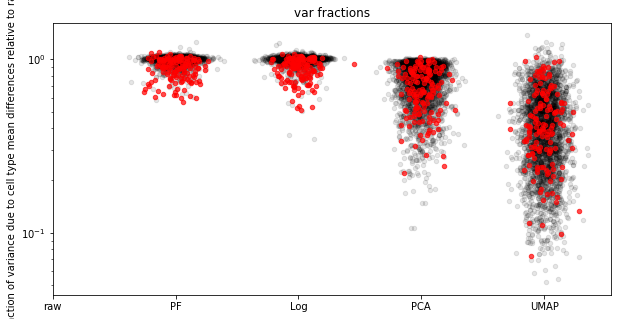

In [206]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(1,5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],var_fracs[k][gf]/var_fracs[0][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],var_fracs[k][~gf]/var_fracs[0][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['raw','PF','Log','PCA','UMAP'])
ax1.set_title('var fractions')
ax1.set_ylabel('Fraction of variance due to cell type mean differences relative to raw')

In [201]:
def get_var_fraction_not_due_to_cts(ad_,layer,subclasses):
    total_variance = ad_.layers[layer].var(0)
    total_mean = ad_.layers[layer].mean(0)
    subclass_means = []
    subclass_abundances = []
    for subclass in subclasses:
        subclass_mean = ad_subset[ad_.obs['subclass_label']==subclass].layers[layer].mean(0)
        subclass_means.append(subclass_mean)
        subclass_abundances.append((ad_.obs['subclass_label']==subclass).mean())
    subclass_abundances = np.asarray(subclass_abundances)
    subclass_means = np.asarray(subclass_means)
    variance_due_to_means = (((subclass_means-total_mean[None,:])**2) * subclass_abundances[:,None]).sum(0) 
    return 1-variance_due_to_means / total_variance
#     return ad_.layers[layer].var(0)/ad_.layers[layer].mean(0)**2
    


In [204]:
var_frac_raw,var_frac_PF,var_frac_log,var_frac_PCA,var_frac_UMAP = [
    get_var_fraction_not_due_to_cts(ad_subset,x,subclasses_to_include) 
                                           for x in ['spliced','spliced_PF','spliced_log','spliced_PCA','spliced_UMAP']]
var_fracs = np.asarray([var_frac_raw,var_frac_PF,var_frac_log,var_frac_PCA,var_frac_UMAP])

Text(0, 0.5, 'Fraction of variance due not due to cell type mean differences')

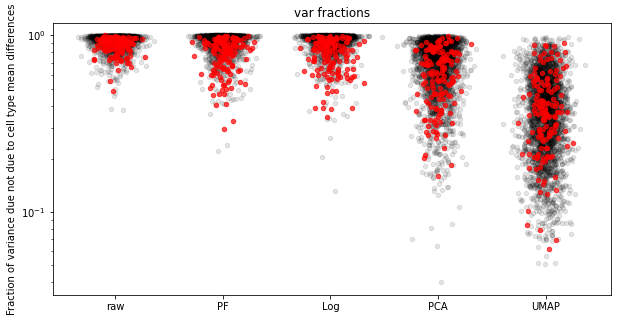

In [205]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],var_fracs[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],var_fracs[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['raw','PF','Log','PCA','UMAP'])
ax1.set_title('var fractions')
ax1.set_ylabel('Fraction of variance due not due to cell type mean differences')

# Normalization analysis

In [19]:
#a e s t h e t i c s
fs = 16

In [20]:
from scipy import stats
import copy

Compute the normalization-based CV$^2$ fractions. Note that there are built-in functions for this functionality in *Monod* under `get_noise_decomp`, but for transparency, we do the computations by hand.

In [21]:
S = copy.deepcopy(sd.layers[1])
U = copy.deepcopy(sd.layers[0])

In [214]:
# dir(sd)

In [31]:
S.shape

(2951, 5343)

In [27]:
C_S = S.sum(0).mean()
S_PF = S/(S.sum(0)[None,:])*C_S
S_log = np.log(S_PF+1)

In [28]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
pca_transformer.fit(S_log.T)
S_PCA_50D = pca_transformer.transform(S_log.T).T
S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [29]:
S_log.shape

(2951, 5343)

In [13]:
pcat_2 = PCA(n_components = 50)

In [53]:
pcat_2.fit_transform(S_PCA.T).T

array([[-7.47669284e+00, -4.81459014e+00, -7.51500841e+00, ...,
        -4.04547954e+00, -2.61099504e+00,  1.54600877e+00],
       [ 7.26213346e-01, -5.23671982e+00, -1.81934709e-01, ...,
        -4.02689587e+00, -9.84165976e+00, -8.07086520e+00],
       [-3.01343876e+00,  4.82944416e+00, -4.88158778e+00, ...,
         2.45416864e+00, -1.04501166e+00, -7.99417213e-01],
       ...,
       [-7.70784231e-01, -3.60814997e-01,  7.85116232e-01, ...,
        -1.76863697e+00, -4.20042909e-01,  3.20856342e-01],
       [ 2.95440211e-01, -9.48161640e-01,  1.73094825e-01, ...,
         1.80620374e-03,  9.94224111e-01,  9.47288087e-02],
       [ 1.61667306e-01,  4.63314489e-01,  9.03142173e-01, ...,
         5.87633961e-03, -8.28518210e-02,  4.47845221e-02]])

In [52]:
S_PCA_50D

array([[-7.47669284, -4.81459014, -7.51500841, ..., -4.04547954,
        -2.61099504,  1.54600877],
       [ 0.72621335, -5.23671982, -0.18193471, ..., -4.02689587,
        -9.84165976, -8.0708652 ],
       [-3.01343876,  4.82944416, -4.88158778, ...,  2.45416864,
        -1.04501166, -0.79941721],
       ...,
       [-0.68988217, -0.26158675,  0.84575561, ..., -1.74011209,
        -0.48888213,  0.31685352],
       [ 0.33223903, -1.01521073,  0.31035902, ..., -0.19777609,
         0.97330272,  0.16107739],
       [ 0.16644237,  0.56056583,  0.82927908, ...,  0.21034857,
        -0.09457292, -0.01501815]])

In [ ]:
#this is by far the slowest part.
import umap
umap_transformer = umap.UMAP()
umap_transformer.fit(S_PCA_50D.T)
S_UMAP_2D = umap_transformer.transform(S_PCA_50D.T).T
S_UMAP_50D = umap_transformer.inverse_transform(S_UMAP_2D.T).T
S_UMAP = pca_transformer.inverse_transform(S_UMAP_50D.T).T

In [55]:
# S_UMAP

Compute the baseline.

In [56]:
dataset_meta = ['B08']
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] 
sd_strings = [dir_string + '/' + x + '/raw.sd' for x in dataset_names]

In [57]:
sd_arr = [monod.analysis.load_search_data(x) for x in sd_strings]

In [58]:
n_cells = np.asarray([x.n_cells for x in sd_arr])
pi = n_cells / np.sum(n_cells)

In [59]:
total_mean = S.mean(1)
total_variance = S.var(1)

In [60]:
subtype_means = np.asarray([x.layers[1].mean(1) for x in sd_arr]).T

In [61]:
baseline = (((subtype_means-total_mean[:,None])**2) * pi[None,:]).sum(1) / total_variance

ValueError: operands could not be broadcast together with shapes (2951,6) (32285,1) 

In [62]:
q = np.quantile(total_mean,0.95)
gf = total_mean<q

In [ ]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF = S_PF.var(1)/S_PF.mean(1)**2
cv2_log = S_log.var(1)/S_log.mean(1)**2
cv2_PCA = S_PCA.var(1)/S_PCA.mean(1)**2
cv2_UMAP = S_UMAP.var(1)/S_UMAP.mean(1)**2

In [ ]:
cv2s = np.asarray([cv2_raw,cv2_PF,cv2_log,cv2_PCA,cv2_UMAP])

In [ ]:
n_genes = sd.n_genes
fig1,ax1 = plt.subplots(1,1,figsize=(10,5))
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    ax1.scatter(xlocs[gf],cv2s[k][gf],20,'k',alpha=0.1)
    ax1.scatter(xlocs[~gf],cv2s[k][~gf],20,'r',alpha=0.7)
ax1.set_yscale('log')
ax1.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'])
ax1.set_title('CV2')


In [ ]:
cv2_raw = S.var(1)/S.mean(1)**2
cv2_PF_frac = cv2_PF / cv2_raw
cv2_log_frac = cv2_log / cv2_raw
cv2_PCA_frac = cv2_PCA / cv2_raw
cv2_UMAP_frac = cv2_UMAP / cv2_raw

In [ ]:
cv2_fracs = np.asarray([cv2_PF_frac,cv2_log_frac,cv2_PCA_frac,cv2_UMAP_frac])

In [ ]:
plt.scatter(baseline[gf],cv2_PF_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PF_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

In [ ]:
plt.scatter(baseline[gf],cv2_log_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_log_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

In [ ]:
plt.scatter(baseline[gf],cv2_PCA_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_PCA_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
plt.yscale('log')

In [ ]:
plt.scatter(baseline[gf],cv2_UMAP_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_UMAP_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,2])

# The upshot

In [ ]:
import pandas as pd
import loompy as lp
import scipy
from scipy import stats

In [ ]:
allen_membership = pd.read_csv('~/count_data/allen_metadata/sc/cluster.membership.csv',skiprows = 1, names=['barcode','cluster_id'])
allen_annot = pd.read_csv('~/count_data/allen_metadata/sc/cluster.annotation.csv')
allen_membership['cell_barcode'] = allen_membership['barcode'].str[:16]
allen_membership['sample'] = allen_membership['barcode'].str[-3:]
allen_membership['cluster_id'] = allen_membership['cluster_id'].astype("category")
allen_annot.set_index('cluster_id',inplace=True)
allen_annot_bc = allen_annot.loc[allen_membership['cluster_id']][['cluster_label','subclass_label','class_label']].set_index(allen_membership.index)
meta = pd.concat((allen_membership,allen_annot_bc),axis=1)
omitted_subtypes = ('L6 IT Car3','L5 ET')

In [ ]:
# allen_annot

In [ ]:
allen_annot[allen_annot['subclass_label']=='L5 IT']

In [ ]:
l5it_clusters = list(allen_annot[allen_annot['subclass_label']=='L5 IT']['cluster_label'])

In [ ]:
list(l5it_clusters)

In [ ]:
allen_annot[allen_annot['subclass_label']=='L6 CT']

In [ ]:
dataset_meta = ['B08']
# 
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
raw_data_locations = [dataset_meta[0] for y in subcluster_names] + [x for x in dataset_meta for y in cluster_names]
transcriptome_filepath = '../polyA_ref/gg_200524_mouse_genome_polyA_cum_1'

spliced_layer = 'spliced'
unspliced_layer = 'unspliced'
gene_attr = 'gene_name'
cell_attr = 'barcode'

attribute_names=[(unspliced_layer,spliced_layer),gene_attr,cell_attr]

loom_filepaths = ['/home/ggorin/count_data/loom_allen_kb/allen_'+x+'_raw.loom' for x in raw_data_locations] 
n_datasets = len(loom_filepaths)


cf = []
cf_clus = []
thr_lb = [1e4]*4

fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

for k in range(len(dataset_meta)):
    filename = loom_filepaths[len(cluster_names)*k + len(subcluster_names)]
    dataset_name = raw_data_locations[len(cluster_names)*k + len(subcluster_names)]
    
    with lp.connect(filename,mode='r') as ds:
        S = ds.layers[spliced_layer][:]
        U = ds.layers[unspliced_layer][:]
        gene_names = ds.ra[gene_attr]
        bcs = ds.ca[cell_attr]
        n_cells = S.shape[1]
        monod.preprocess.knee_plot(S+U,ax1,viz=True,thr=thr_lb[k])
        cf_ = ((S+U).sum(0)>thr_lb[k])
        
        n_annot_bcs = (meta['sample']==dataset_name).sum()
        annot_bcs_in_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs).sum()
        annot_bcs_in_filt_loom = meta[(meta['sample']==dataset_name)]['cell_barcode'].isin(bcs[cf_]).sum()
        print(f'Dataset {dataset_name}. \n\t{len(bcs)} barcodes in loom, {cf_.sum()} pass filter. {n_annot_bcs} in annotations; of these, {annot_bcs_in_loom} in loom and {annot_bcs_in_filt_loom} in filtered loom.')
        if k==0:
            for subcluster in subcluster_names:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label'].str.replace(' ','').str.replace('/','')==subcluster) \
                                           & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
                cf.append(np.isin(bcs,annot_bcs) & cf_)
                print(f'\t{subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
                
            for subcluster in omitted_subtypes:
                annot_bcs = meta[(meta['sample']==dataset_name) \
                                           & (meta['subclass_label']==subcluster) ]['cell_barcode']
                CF_ = np.isin(bcs,annot_bcs) & cf_
                print(f'\tOmitted -- {subcluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {CF_.sum()} pass filter.')
        
        for cluster in cluster_names:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['class_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf[-1].sum()} pass filter.')
            
            
        for cluster in l5it_clusters:
            annot_bcs = meta[(meta['sample']==dataset_name) \
                                       & (meta['cluster_label']==cluster) \
                                       & ~(meta['subclass_label'].isin(omitted_subtypes))]['cell_barcode']
            cf_clus.append(np.isin(bcs,annot_bcs) & cf_)
            print(f'\t{cluster}: {len(annot_bcs)} cells in annotations. {np.isin(bcs,annot_bcs).sum()} in loom. {cf_clus[-1].sum()} pass filter.')

    ax1.set_title(dataset_name)
fig1.tight_layout()


In [ ]:
np.array(cf_clus).sum(1)

In [ ]:
# subtype_inds

In [ ]:
subtype_filters = np.zeros((6,sum(cf[-1])),dtype=bool)
glu_inds = np.where(cf[-1])[0]
for i in range(6):
    subtype_inds = np.where(cf[i])[0]
    subtype_filters[i] = [ind in subtype_inds for ind in glu_inds]

In [ ]:
len(glu_inds)


In [ ]:
cluster_filters = np.zeros((4,sum(cf[-1])),dtype=bool)
glu_inds = np.where(cf[-1])[0]
for i in range(4):
    cluster_inds = np.where(cf_clus[i])[0]
    cluster_filters[i] = [ind in cluster_inds for ind in glu_inds]

In [ ]:
cluster_filters.sum()

In [ ]:
gene_ind_loom = np.where(gene_names == 'Cplx2')[0][0]
# gene_ind_loom = np.where(gene_names == 'Slc30a3')[0][0]

In [ ]:
S.shape

In [ ]:
S1 = S[gene_ind_loom][cf[1]]
S2 = S[gene_ind_loom][cf[4]]


In [ ]:
fig1,ax1 = plt.subplots(1,2,figsize=(8,4))
bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')
# ax1[0].hist(Sall,alpha=0.4)

In [ ]:
n_cells

In [165]:
subcluster_names

['L23IT', 'L5IT', 'L6IT', 'L56NP', 'L6CT', 'L6b']

In [166]:
for z in zip(subcluster_names,n_cells):
    print(z)

TypeError: 'int' object is not iterable

In [167]:
c1 = 1
c2 = 4

Illustration: which gene has the highest difference in means between L5IT and L6CT types?

In [168]:
# sorted_genes = np.argsort(np.abs(subtype_means[:,c1]-subtype_means[:,c2]))
# maxind = sorted_genes[-1]
# print(sd.gene_names[maxind])


In [205]:
sorted_genes = np.argsort(cv2_PCA_frac)
sorted_genes = np.argsort(cv2_UMAP_frac)
maxind = sorted_genes[-1]
print(sd.gene_names[maxind])
print(sd.gene_names[sorted_genes[-2:]])

Slc38a9
['Sulf2' 'Slc38a9']


In [210]:
sd.gene_names[sorted_genes[1]]

'Dnm1'

In [170]:
# np.abs(subtype_means[maxind,1]-subtype_means[maxind,4])

In [171]:
S1 = sd_arr[1].layers[1,maxind]
S2 = sd_arr[4].layers[1,maxind]
S1 = sd.layers[1,maxind,subtype_filters[1]]
S2 = sd.layers[1,maxind,subtype_filters[4]]
Sall = sd.layers[1,maxind]

In [173]:
# S.sum(0)[subtype_filters[1]]

In [111]:
# S = S[:,glu_inds]

In [112]:
S.shape

(32285, 5343)

In [96]:
S.sum(0).shape

(5343,)

In [97]:
subtype_filters[0].shape

(5343,)

hi


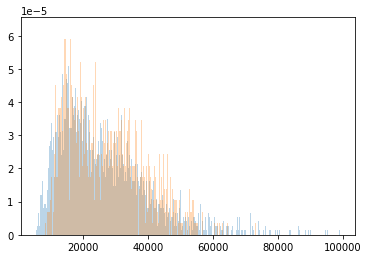

In [98]:
plt.hist(S.sum(0)[subtype_filters[1]],300,alpha=0.3,density=True)
plt.hist(S.sum(0)[subtype_filters[4]],300,alpha=0.3,density=True)
print('hi')

In [99]:
subtype_filters.shape

(6, 5343)

In [193]:
S.shape

(2951, 5343)

KstestResult(statistic=0.10493555378769126, pvalue=1.1871540195329544e-08)
KstestResult(statistic=0.1353798777150207, pvalue=4.2743586448068527e-14)
KstestResult(statistic=0.1353798777150207, pvalue=4.2743586448068527e-14)
KstestResult(statistic=0.4898126294797881, pvalue=1.149979092845226e-189)
KstestResult(statistic=0.7376800119425322, pvalue=0.0)


Text(0.5, 0, '# RNA')

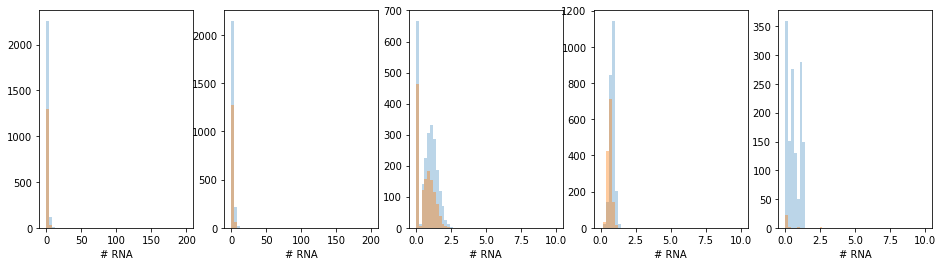

In [194]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[maxind,subtype_filters[c1]]
S2 = S[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')

S1 = S_PF[maxind,subtype_filters[c1]]
S2 = S_PF[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[1].hist(S1,bins,alpha=0.3)
ax1[1].hist(S2,bins,alpha=0.4)
ax1[1].set_xlabel('# RNA')


S1 = S_log[maxind,subtype_filters[c1]]
S2 = S_log[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,10)
ax1[2].hist(S1,bins,alpha=0.3)
ax1[2].hist(S2,bins,alpha=0.4)
ax1[2].set_xlabel('# RNA')


S1 = S_PCA[maxind,subtype_filters[c1]]
S2 = S_PCA[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))



bins = np.linspace(0,10)
ax1[3].hist(S1,bins,alpha=0.3)
ax1[3].hist(S2,bins,alpha=0.4)
ax1[3].set_xlabel('# RNA')


S1 = S_UMAP[maxind,subtype_filters[c1]]
S2 = S_UMAP[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))


bins = np.linspace(0,10)
ax1[4].hist(S1,bins,alpha=0.3)
ax1[4].hist(S2,bins,alpha=0.4)
ax1[4].set_xlabel('# RNA')


KstestResult(statistic=0.10493555378769126, pvalue=1.1871540195329544e-08)
KstestResult(statistic=0.1353798777150207, pvalue=4.2743586448068527e-14)
KstestResult(statistic=0.1353798777150207, pvalue=4.2743586448068527e-14)
KstestResult(statistic=0.4898126294797881, pvalue=1.149979092845226e-189)
KstestResult(statistic=0.7376800119425322, pvalue=0.0)


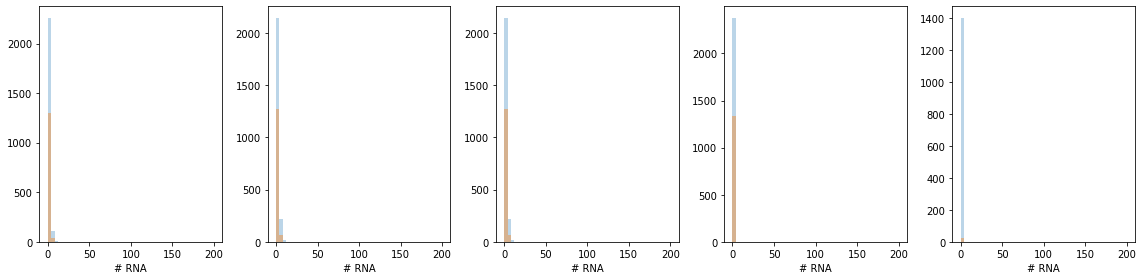

In [195]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[maxind,subtype_filters[c1]]
S2 = S[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[0].hist(S1,bins,alpha=0.3)
ax1[0].hist(S2,bins,alpha=0.4)
ax1[0].set_xlabel('# RNA')

S1 = S_PF[maxind,subtype_filters[c1]]
S2 = S_PF[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[1].hist(S1,bins,alpha=0.3)
ax1[1].hist(S2,bins,alpha=0.4)
ax1[1].set_xlabel('# RNA')


S1 = S_log[maxind,subtype_filters[c1]]
S2 = S_log[maxind,subtype_filters[c2]]
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[2].hist(S1,bins,alpha=0.3)
ax1[2].hist(S2,bins,alpha=0.4)
ax1[2].set_xlabel('# RNA')


S1 = S_PCA[maxind,subtype_filters[c1]]
S2 = S_PCA[maxind,subtype_filters[c2]]
print(scipy.stats.kstest(S1,S2))
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1

bins = np.linspace(0,200)
ax1[3].hist(S1,bins,alpha=0.3)
ax1[3].hist(S2,bins,alpha=0.4)
ax1[3].set_xlabel('# RNA')


S1 = S_UMAP[maxind,subtype_filters[c1]]
S2 = S_UMAP[maxind,subtype_filters[c2]]
S1 = np.exp(S1)-1
S2 = np.exp(S2)-1
print(scipy.stats.kstest(S1,S2))

bins = np.linspace(0,200)
ax1[4].hist(S1,bins,alpha=0.3)
ax1[4].hist(S2,bins,alpha=0.4)
ax1[4].set_xlabel('# RNA')

fig1.tight_layout()

In [181]:
top_2 = sorted_genes[-2:]

In [182]:
sorted_genes

array([1903, 1632, 1149, ...,  567, 1642,  752])

In [211]:
# gene_names[top_2[0]]

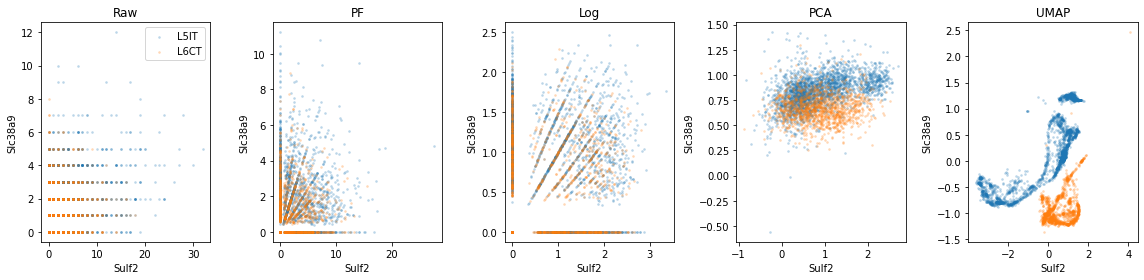

In [212]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S1 = S[top_2][:,subtype_filters[c1]]
S2 = S[top_2][:,subtype_filters[c2]]

ax1[0].scatter(S1[0],S1[1],alpha=0.2,s=3,label=subcluster_names[c1])
ax1[0].scatter(S2[0],S2[1],alpha=0.2,s=3,label=subcluster_names[c2])
ax1[0].legend()

S1 = S_PF[top_2][:,subtype_filters[c1]]
S2 = S_PF[top_2][:,subtype_filters[c2]]

ax1[1].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[1].scatter(S2[0],S2[1],alpha=0.2,s=3)

S1 = S_log[top_2][:,subtype_filters[c1]]
S2 = S_log[top_2][:,subtype_filters[c2]]

ax1[2].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[2].scatter(S2[0],S2[1],alpha=0.2,s=3)

S1 = S_PCA[top_2][:,subtype_filters[c1]]
S2 = S_PCA[top_2][:,subtype_filters[c2]]

ax1[3].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[3].scatter(S2[0],S2[1],alpha=0.2,s=3)


S1 = S_UMAP[top_2][:,subtype_filters[c1]]
S2 = S_UMAP[top_2][:,subtype_filters[c2]]

ax1[4].scatter(S1[0],S1[1],alpha=0.2,s=3)
ax1[4].scatter(S2[0],S2[1],alpha=0.2,s=3)

steps = ['Raw','PF','Log','PCA','UMAP']
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel(sd.gene_names[top_2[0]])
    ax.set_ylabel(sd.gene_names[top_2[1]])
fig1.tight_layout()

In [197]:
S1 = S[top_2][:,subtype_filters[c1]]
S2 = S[top_2][:,subtype_filters[c2]]


In [198]:
S1.max()

32

In [199]:
S2.max()

18

In [200]:
S1 = S_PF[top_2][:,subtype_filters[c1]]
S2 = S_PF[top_2][:,subtype_filters[c2]]



In [201]:
S1.max()

27.723546338670616

In [202]:
S2.max()

15.526014974353009

In [203]:
S[gene_names=='Gm28826'].max()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 2951 but corresponding boolean dimension is 32285

In [137]:
S.shape

(32285, 5343)

In [134]:
sd.gene_names.shape

(2951,)

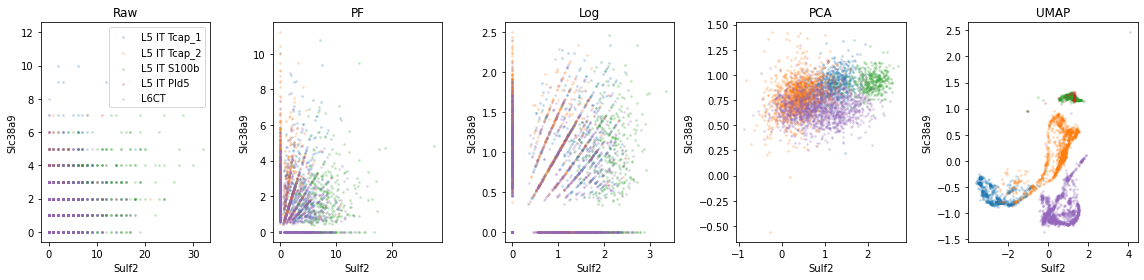

In [213]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

S2 = S[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S[top_2][:,cluster_filters[i]]
    ax1[0].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[0].scatter(S2[0],S2[1],alpha=0.2,s=3,label=subcluster_names[c2])
ax1[0].legend()

S2 = S_PF[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_PF[top_2][:,cluster_filters[i]]
    ax1[1].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[1].scatter(S2[0],S2[1],alpha=0.2,s=3)

S2 = S_log[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_log[top_2][:,cluster_filters[i]]
    ax1[2].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[2].scatter(S2[0],S2[1],alpha=0.2,s=3)

S2 = S_PCA[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_PCA[top_2][:,cluster_filters[i]]
    ax1[3].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[3].scatter(S2[0],S2[1],alpha=0.2,s=3)


S2 = S_UMAP[top_2][:,subtype_filters[c2]]

for i in range(4):
    S1 = S_UMAP[top_2][:,cluster_filters[i]]
    ax1[4].scatter(S1[0],S1[1],alpha=0.2,s=3,label=l5it_clusters[i])
ax1[4].scatter(S2[0],S2[1],alpha=0.2,s=3)

steps = ['Raw','PF','Log','PCA','UMAP']
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel(sd.gene_names[top_2[0]])
    ax.set_ylabel(sd.gene_names[top_2[1]])
fig1.tight_layout()

In [123]:
U.shape

(32285, 10975)

# Correlations between U/S?

In [231]:
SU_corr = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S,U)])


In [232]:
SU_corr.shape

(2951,)

In [216]:
import sklearn
from sklearn import feature_selection

In [217]:
S[0].shape

(5343,)

In [218]:
S.shape

(2951, 5343)

In [219]:
U.shape


(2951, 5343)

In [220]:
# SU_mut = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y)[0] for x,y in zip(S,U)])


In [ ]:
SU_mut

In [ ]:
SU_mut_disc = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=True)[0] for x,y in zip(S,U)])


In [234]:
# bins = np.linspace(0,.6)
# plt.hist(SU_mut,bins,alpha=0.5)
# plt.hist(SU_mut_disc,bins,alpha=0.5)

In [235]:
SU_corr_l6 = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S[:,subtype_filters[c2]],U[:,subtype_filters[c2]])])


In [236]:
S_shuffled = np.copy(S)
np.random.shuffle(S_shuffled)
SU_corr_rand = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_shuffled,U)])
SU_corr_l6_rand = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_shuffled[:,subtype_filters[c2]],U[:,subtype_filters[c2]])])


In [243]:
# sd.gene_names.shape

In [238]:
S_shuffled.shape

(2951, 5343)

(array([  3.,   4.,  26.,  61., 126., 185., 225., 251., 243., 249., 209.,
        200., 173., 156., 126., 123., 122.,  83.,  69.,  79.,  51.,  55.,
         46.,  22.,  21.,  19.,  13.,   6.,   3.,   2.]),
 array([0.02054576, 0.04768343, 0.07482111, 0.10195878, 0.12909645,
        0.15623413, 0.1833718 , 0.21050947, 0.23764714, 0.26478482,
        0.29192249, 0.31906016, 0.34619784, 0.37333551, 0.40047318,
        0.42761085, 0.45474853, 0.4818862 , 0.50902387, 0.53616154,
        0.56329922, 0.59043689, 0.61757456, 0.64471224, 0.67184991,
        0.69898758, 0.72612525, 0.75326293, 0.7804006 , 0.80753827,
        0.83467595]),
 <BarContainer object of 30 artists>)

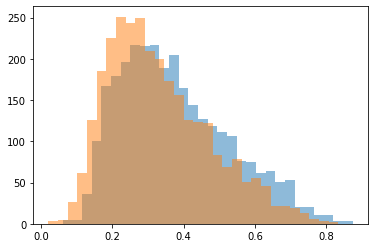

In [239]:
plt.hist(SU_corr,30,alpha=0.5)
plt.hist(SU_corr_l6,30,alpha=0.5)

(array([  8.,  18.,  39.,  55., 111., 169., 246., 292., 266., 247., 264.,
        228., 222., 165., 142., 100.,  83.,  85.,  58.,  50.,  35.,  26.,
         21.,  11.,   3.,   3.,   1.,   1.,   0.,   2.]),
 array([0.00942508, 0.03347374, 0.0575224 , 0.08157106, 0.10561972,
        0.12966838, 0.15371704, 0.1777657 , 0.20181435, 0.22586301,
        0.24991167, 0.27396033, 0.29800899, 0.32205765, 0.34610631,
        0.37015497, 0.39420363, 0.41825229, 0.44230094, 0.4663496 ,
        0.49039826, 0.51444692, 0.53849558, 0.56254424, 0.5865929 ,
        0.61064156, 0.63469022, 0.65873887, 0.68278753, 0.70683619,
        0.73088485]),
 <BarContainer object of 30 artists>)

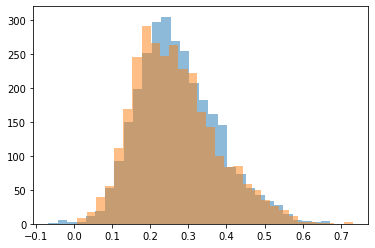

In [245]:
# plt.hist(SU_corr,30,alpha=0.5)
# plt.hist(SU_corr_l6,30,alpha=0.5)
plt.hist(SU_corr_rand,30,alpha=0.5)
plt.hist(SU_corr_l6_rand,30,alpha=0.5)

In [246]:
SU_concat = np.concatenate((S,U))

In [247]:
# S_concat_PF.shape

In [248]:
C_SU_concat = SU_concat.sum(0).mean()
SU_concat_PF = SU_concat/(SU_concat.sum(0)[None,:])*C_SU_concat
SU_concat_log = np.log(SU_concat_PF+1)

In [249]:
np.corrcoef(SU_concat).shape

(5902, 5902)

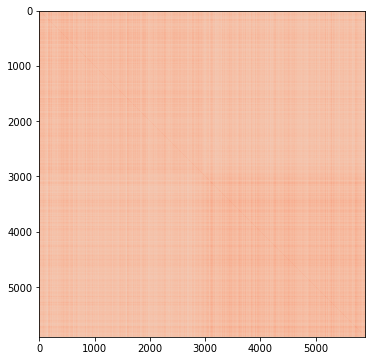

In [250]:
fig1,ax1=plt.subplots(figsize=(6,6))
plt.imshow(np.corrcoef(SU_concat),vmin=-1,vmax=1,cmap='coolwarm')

In [251]:
S_concat_PF,U_concat_PF = np.array_split(SU_concat_PF,2,0)
SU_corr_PF = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_PF,U_concat_PF)])

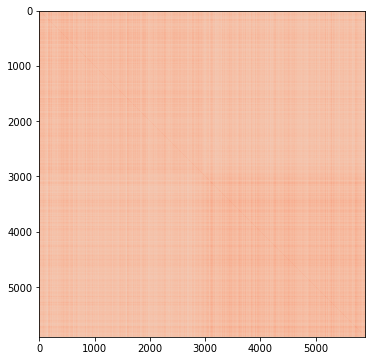

In [252]:
fig1,ax1=plt.subplots(figsize=(6,6))
plt.imshow(np.corrcoef(SU_concat),vmin=-1,vmax=1,cmap='coolwarm')

In [253]:
S_concat_log,U_concat_log = np.array_split(SU_concat_log,2,0)
SU_corr_log = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_log,U_concat_log)])

In [254]:
from sklearn.decomposition import PCA
pca_transformer = PCA(n_components=50)
pca_transformer.fit(SU_concat_log.T)
SU_PCA_50D = pca_transformer.transform(SU_concat_log.T).T
SU_concat_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

In [255]:
S_concat_PCA,U_concat_PCA = np.array_split(SU_concat_PCA,2,0)
SU_corr_PCA = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_PCA,U_concat_PCA)])

In [256]:
SU_concat_PCA.shape

(5902, 5343)

In [257]:
#this is by far the slowest part.
import umap
umap_transformer = umap.UMAP()
umap_transformer.fit(SU_PCA_50D.T)
SU_UMAP_2D = umap_transformer.transform(SU_PCA_50D.T).T
SU_UMAP_50D = umap_transformer.inverse_transform(SU_UMAP_2D.T).T
SU_concat_UMAP = pca_transformer.inverse_transform(SU_UMAP_50D.T).T

In [258]:
S_concat_UMAP,U_concat_UMAP = np.array_split(SU_concat_UMAP,2,0)
SU_corr_UMAP = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(S_concat_UMAP,U_concat_UMAP)])

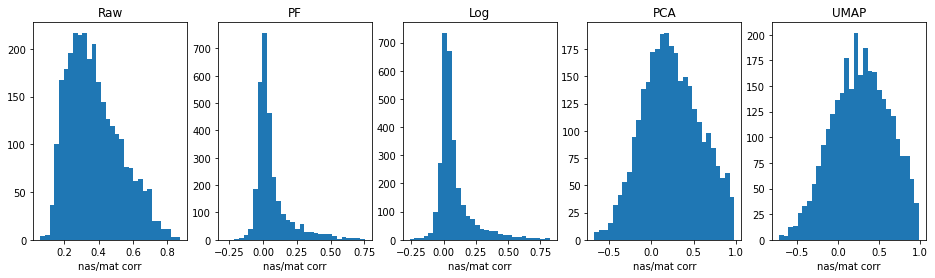

In [259]:
fig1,ax1 = plt.subplots(1,5,figsize=(16,4))

ax1[0].hist(SU_corr,30)
ax1[1].hist(SU_corr_PF,30)
ax1[2].hist(SU_corr_log,30)
ax1[3].hist(SU_corr_PCA,30)
ax1[4].hist(SU_corr_UMAP,30)
for i,ax in enumerate(ax1):
    ax.set_title(steps[i])
    ax.set_xlabel('nas/mat corr')

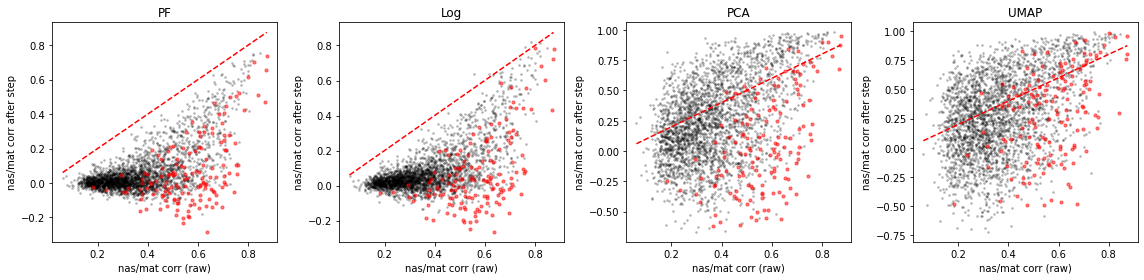

In [260]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_corr[gf],SU_corr_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_corr[~gf],SU_corr_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_corr[gf],SU_corr_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_corr[~gf],SU_corr_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_corr[gf],SU_corr_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_corr[~gf],SU_corr_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_corr[gf],SU_corr_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_corr[~gf],SU_corr_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat corr (raw)')
    ax.set_ylabel('nas/mat corr after step')
fig1.tight_layout()

In [708]:
SU_mut_PF = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_PF,U_concat_PF)])


In [709]:
SU_mut_log = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_log,U_concat_log)])


In [712]:
SU_mut_PCA = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_PCA,U_concat_PCA)])


In [715]:
SU_mut_UMAP = np.array([sklearn.feature_selection.mutual_info_regression(x[:,None],y,discrete_features=False)[0] for x,y in zip(S_concat_UMAP,U_concat_UMAP)])


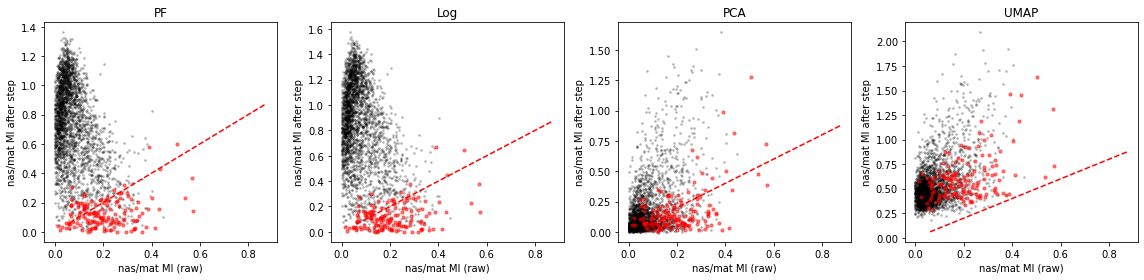

In [731]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_mut[gf],SU_mut_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_mut[~gf],SU_mut_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_mut[gf],SU_mut_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_mut[~gf],SU_mut_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_mut[gf],SU_mut_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_mut[~gf],SU_mut_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_mut[gf],SU_mut_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_mut[~gf],SU_mut_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat MI (raw)')
    ax.set_ylabel('nas/mat MI after step')
fig1.tight_layout()

In [494]:
gf.sum()

2803

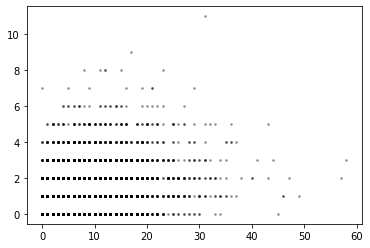

In [334]:
plt.scatter(S[0],S[1],3,'k',alpha=0.3)

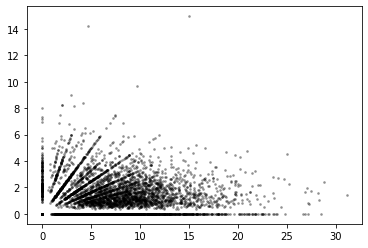

In [335]:
plt.scatter(S_PF[0],S_PF[1],3,'k',alpha=0.3)

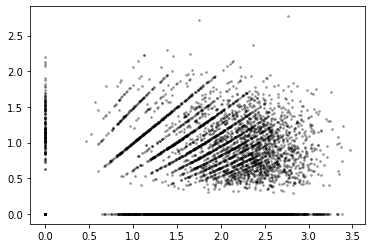

In [226]:
plt.scatter(S_log[0],S_log[1],3,'k',alpha=0.3)

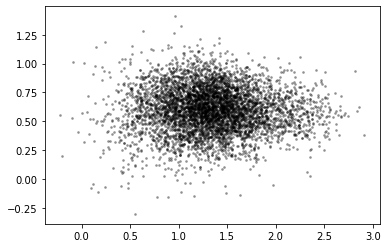

In [227]:
i=10
plt.scatter(S_PCA[i],S_PCA[i+4],3,'k',alpha=0.3)

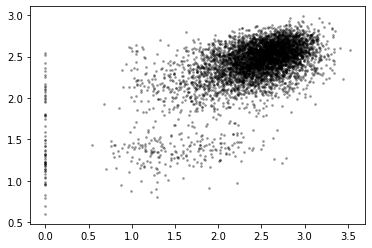

In [245]:
i=700

plt.scatter(S_log[i],S_PCA[i],3,'k',alpha=0.3)

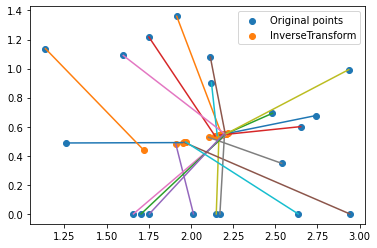

In [261]:
# X_orig = np.random.rand(20, 2)
X_orig = S_log[:,:20].T
pca = PCA(1)
pca.fit(X_orig)
X_transf = pca.transform(X_orig).T
X_re_orig = pca.inverse_transform(X_transf.T)

plt.scatter(X_orig[:, 0], X_orig[:, 1], label='Original points')
plt.scatter(X_re_orig[:, 0], X_re_orig[:, 1], label='InverseTransform')
[plt.plot([X_orig[i, 0], X_re_orig[i, 0]], [X_orig[i, 1], X_re_orig[i, 1]]) for i in range(len(X_orig))]
plt.legend()
plt.show()


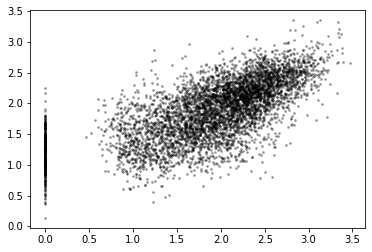

In [250]:
plt.scatter(S_log[0],S_PCA[0],3,'k',alpha=0.3)

In [255]:
# S_PCA.shape

In [256]:
pca_transformer = PCA(n_components=50)
pca_transformer.fit(S_log.T)
# S_PCA_50D = pca_transformer.transform(S_log.T).T
# S_PCA = pca_transformer.inverse_transform(S_PCA_50D.T).T

PCA(n_components=50)

In [220]:
S_PCA.shape

(2951, 5343)

# *Monod*

Perform analysis on mechanistic fit.

In [72]:
subcluster_names = ['L2/3 IT','L5 IT','L6 IT','L5/6 NP', 'L6 CT', 'L6b']
subcluster_names = [x.replace(' ','').replace('/','') for x in subcluster_names]
cluster_names = ['Glutamatergic']
dataset_names = ['allen_'+dataset_meta[0]+'_'+y  for y in subcluster_names] \
              + ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names]  
n_datasets = len(dataset_names)

In [73]:
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]


In [74]:
result_strings

['./fits/gg_230328_026_allen_celltypes_1/allen_B08_L23IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L5IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6IT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L56NP/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6CT/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_L6b/Bursty_Poisson_20x21/grid_scan_results_upd.res',
 './fits/gg_230328_026_allen_celltypes_1/allen_B08_Glutamatergic/Bursty_Poisson_20x21/grid_scan_results_upd.res']

Import results.

In [76]:
opt = []
n_cells = []
sr_arr = []
for i in range(n_datasets):
    sr = monod.analysis.load_search_results(result_strings[i])
    opt.append(sr.samp_optimum)
    n_cells.append(sr.n_cells)
    sr_arr.append(sr)
opt = np.asarray(opt)
n_cells = np.asarray(n_cells)


In [77]:
xl = np.asarray([sr.sp.samp_lb[0],sr.sp.samp_ub[0]])
yl = np.asarray([sr.sp.samp_lb[1],sr.sp.samp_ub[1]])
x=np.linspace(xl[0],xl[1],sr.sp.gridsize[0])
y=np.linspace(yl[0],yl[1],sr.sp.gridsize[1])

Where should we set the sampling parameters? The results for low-abundance cell types are questionable. We somewhat arbitrarily set the parameters for all to the glutamatergic result.

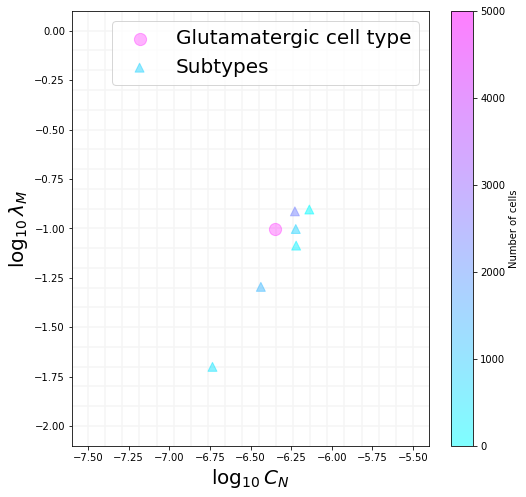

In [78]:
fs = 20

d=0.1

fig1,ax1 = plt.subplots(1,1,figsize=(8,8))
for i in range(sr.sp.gridsize[0]):
    plt.plot([x[i]]*2,yl + [-d,d],c='whitesmoke')
for i in range(sr.sp.gridsize[1]):
    plt.plot(xl+ [-d,d],[y[i]]*2,c='whitesmoke')
jit = np.random.randn(n_datasets,2)*0.01
opt_ = opt+jit
cmap = 'cool'

ctf = range(6,n_datasets)
plt.scatter(opt_[ctf,0],opt_[ctf,1],150,n_cells[ctf],zorder=1000,
            alpha=0.3,cmap=cmap,label='Glutamatergic cell type',vmin=0,vmax=5000)
stf = range(6)
plt.scatter(opt_[stf,0],opt_[stf,1],80,n_cells[stf],marker='^',zorder=1000,
            alpha=0.5,cmap=cmap,label='Subtypes',vmin=0,vmax=5000)
plt.xlim(xl+ [-d,d])
plt.ylim(yl+ [-d,d])

plt.legend(fontsize=fs,loc='upper right')
plt.colorbar(label='Number of cells')

plt.xlabel(r'$\log_{10} C_N$',fontsize=fs)
plt.ylabel(r'$\log_{10} \lambda_M$',fontsize=fs)

fig_string = './figs/landscape_qc_allen.png'
plt.savefig(fig_string,dpi=450)


For this analysis, we ignore goodness of fit and confidence intervals.

In [82]:
# model_moments.shape

In [83]:
model_moments = []
li = sr_arr[-1].samp_optimum_ind
for j in range(n_datasets-1):

    p = 10**sr_arr[j].param_estimates[li] #b, beta, gamma
    l = 10**sr_arr[j].regressor[li]
    
    p=p.T
    l=l.T
    mu_bio =  p[0]/p[2]
    mu_tech = mu_bio * l[1]
    var_bio = mu_bio*(1+p[0]*p[1]/(p[1]+p[2]))
    var_tech = mu_tech*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
    model_moments.append((mu_bio,mu_tech,var_bio,var_tech))
    
model_moments = np.asarray(model_moments)


In [84]:
mean_bio = (model_moments[:,0,:]*pi[:,None]).sum(0)
var_bio = (model_moments[:,2,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,0,:]-mean_bio)**2)*pi[:,None]).sum(0)

mean_tech = (model_moments[:,1,:]*pi[:,None]).sum(0)
var_tech = (model_moments[:,3,:]*pi[:,None]).sum(0) \
        + (((model_moments[:,1,:]-mean_tech)**2)*pi[:,None]).sum(0)

cv2_bio = var_bio/mean_bio**2
cv2_tech = var_tech/mean_tech**2
cv2_monod_frac = cv2_bio/cv2_tech


(-0.1, 1.0)

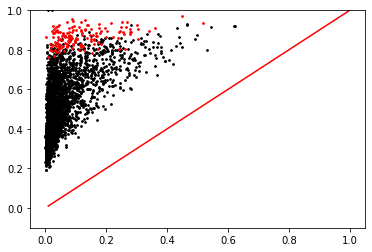

In [85]:
plt.scatter(baseline[gf],cv2_monod_frac[gf],3,'k')
plt.scatter(baseline[~gf],cv2_monod_frac[~gf],3,'r')
xl = np.linspace(0.01,1)
plt.plot(xl,xl,'r-')
# plt.yscale('log')
plt.ylim([-0.1,1])

# Fig 1 b-h

Plot the noise fractions and attributions for the PF, log, PCA, and UMAP.

In [86]:
# a e s t h e t i c s
c_genes = 'dimgrey'
alpha_genes = 0.1
c_highlight = 'tomato'
alpha_highlight = 0.7
c_baseline = np.asarray([9,160,115])/255
c_singlegene = 'dodgerblue'
ms_genes = 20
ms_highlight = 20
fs_axes = 12
fs_title=14
alpha_line = 0.48
lw = 3
c_baseline_violation = 'blueviolet'
c_identity = 'k'

0.0
0.08166723144696712
0.35140630294815317
0.09081667231446967


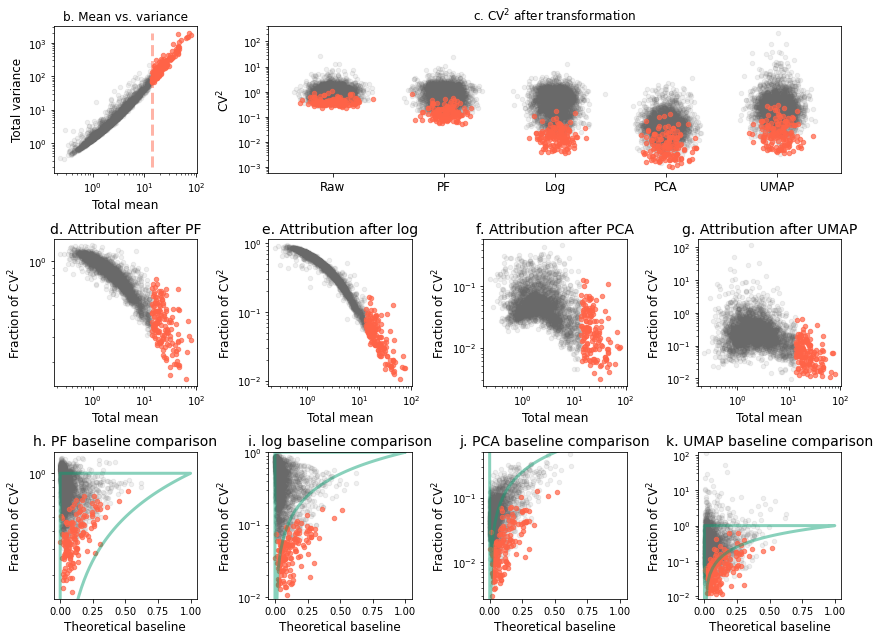

In [87]:
fig1,ax1=plt.subplots(3,4,figsize=(12,9))

fl = 97+1
#mean-variance relationship
ax1[0,0].scatter(total_mean[gf],total_variance[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0,0].scatter(total_mean[~gf],total_variance[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0,0].plot([q]*2,[2e-1,2e3],'--',color=c_highlight,alpha=alpha_line,linewidth=lw)
ax1[0,0].set_xscale('log')
ax1[0,0].set_yscale('log')
ax1[0,0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0,0].set_ylabel('Total variance',fontsize=fs_axes)
ax1[0,0].set_title('{}. Mean vs. variance'.format(chr(fl)))

#cv2
gs = ax1[0,1].get_gridspec()
for ax in ax1[0,1:]:
    ax.remove()
axcv2 = fig1.add_subplot(gs[0,1:])
for k in range(5):
    xlocs = k+np.random.randn(n_genes)/10
    axcv2.scatter(xlocs[gf],cv2s[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    axcv2.scatter(xlocs[~gf],cv2s[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
axcv2.set_yscale('log')
axcv2.set_xticks(np.arange(5),['Raw','PF','Log','PCA','UMAP'],fontsize=fs_axes)
axcv2.set_ylabel(r'CV$^2$',fontsize=fs_axes)
axcv2.set_title('{}. CV$^2$ after transformation'.format(chr(fl+1)))

#mean dependence
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(total_mean[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(total_mean[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    ax1[1,k].set_xscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_xlabel('Total mean',fontsize=fs_axes)
    ax1[1,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    ax1[1,k].set_title('{}. Attribution after {}'.format(chr(fl+2+k),names[k]),fontsize=fs_title)

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[2,k].scatter(baseline[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[2,k].scatter(baseline[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    
    
    gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    print(gf_.sum()/len(gf_))
    
    ax1[2,k].set_yscale('log')
    ax1[2,k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[2,k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[2,k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[2,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[2,k].set_xticks(np.linspace(0,1,5))
    ax1[2,k].set_title('{}. {} baseline comparison'.format(chr(fl+6+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig1b_k.png',dpi=450)
fig1.savefig('./figs/fig1b_k.pdf')


## Supplement to Fig. 1

Even if UMAP inflates the CV$^2$, how much information have we lost previously in the process?

0.0
0.08166723144696712
0.35140630294815317
0.35547272111148764


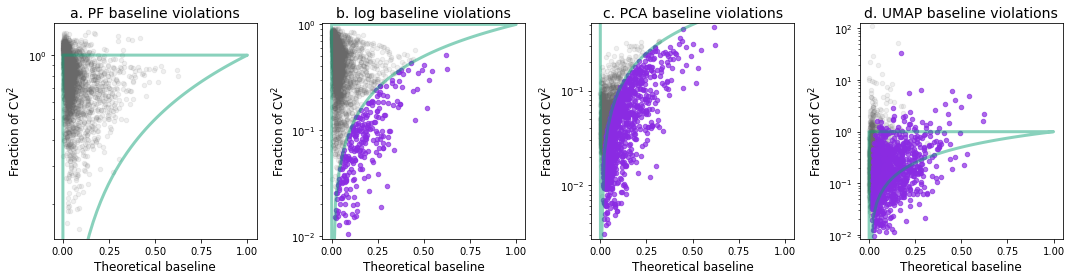

In [88]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))

#baseline comparison
names = ['PF','log','PCA','UMAP']
for k in range(4):
    if k==0:
        gf_ = cv2_fracs[k]<baseline #can also add a CV2 fraction >1 criterion here...
    else:
        gf_ = gf_|(cv2_fracs[k]<baseline)
    print(gf_.sum()/len(gf_))
    ax1[k].scatter(baseline[~gf_],cv2_fracs[k][~gf_],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(baseline[gf_],cv2_fracs[k][gf_],ms_highlight,c_baseline_violation,alpha=alpha_highlight)
    ax1[k].set_yscale('log')
    ax1[k].set_xlabel('Theoretical baseline',fontsize=fs_axes)
    ax1[k].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
    xmin = 0.001
    region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
    region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
    ax1[k].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
                           
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xticks(np.linspace(0,1,5))
    ax1[k].set_title('{}. {} baseline violations'.format(chr(97+k),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/baseline_violation.png',dpi=450)
fig1.savefig('./figs/baseline_violation.pdf')


# Fig 2 b-c

How much of the CV$^2$ does a mechanistic approach ascribe to biology?

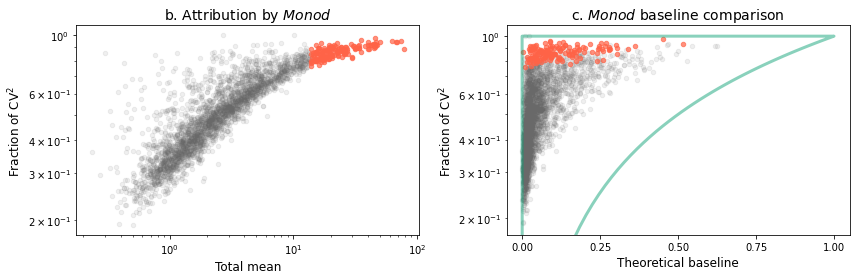

In [89]:
fig1,ax1=plt.subplots(1,2,figsize=(12,4))

# #mean dependence
ax1[0].scatter(total_mean[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[0].scatter(total_mean[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[0].set_xscale('log')
ax1[0].set_yscale('log')
ax1[0].set_xlabel('Total mean',fontsize=fs_axes)
ax1[0].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1[0].set_title('{}. '.format(chr(97+1))+r'Attribution by $\it{Monod}$',fontsize=fs_title)


ax1[1].scatter(baseline[gf],cv2_monod_frac[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1[1].scatter(baseline[~gf],cv2_monod_frac[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1[1].set_yscale('log')
ax1[1].set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1[1].set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1[1].plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1[1].set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1[1].set_xticks(np.linspace(0,1,5))
ax1[1].set_title('{}. '.format(chr(97+2))+r'$\it{Monod}$ baseline comparison',fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/fig2bc.png',dpi=450)
fig1.savefig('./figs/fig2bc.pdf')


## Supplements to Fig. 2

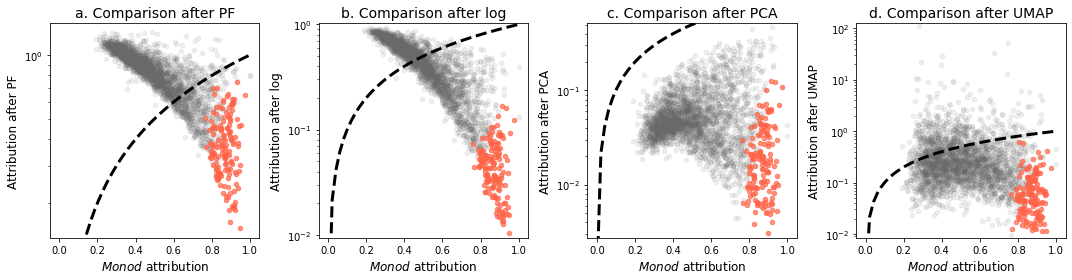

In [90]:
fig1,ax1=plt.subplots(1,4,figsize=(15,4))
names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[k].scatter(cv2_monod_frac[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[k].scatter(cv2_monod_frac[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[k].set_yscale('log')
    ax1[k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[k].set_title('{}. Comparison after {}'.format(chr(97+k),names[k]),fontsize=fs_title)
fig1.tight_layout()
fig1.savefig('./figs/monod_norm_comparison.png',dpi=450)
fig1.savefig('./figs/monod_norm_comparison.pdf')


What if we fit the entire dataset using *Monod*, without giving the cell type annotations? After all, our aggregation procedure "automatically" applies the law of total variance. It turns out this makes very little difference.

In [91]:
# model_moments = []
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[-1].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[-1].regressor[li]

p=p.T
l=l.T
mu_bio_glu =  p[0]/p[2]
mu_tech_glu = mu_bio_glu * l[1]
var_bio_glu = mu_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
var_tech_glu = mu_tech_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
cv2_bio_glu = var_bio_glu/mu_bio_glu**2
cv2_tech_glu = var_tech_glu/mu_tech_glu**2
cv2_monod_frac_glu = cv2_bio_glu/cv2_tech_glu


In [93]:
# p.sha

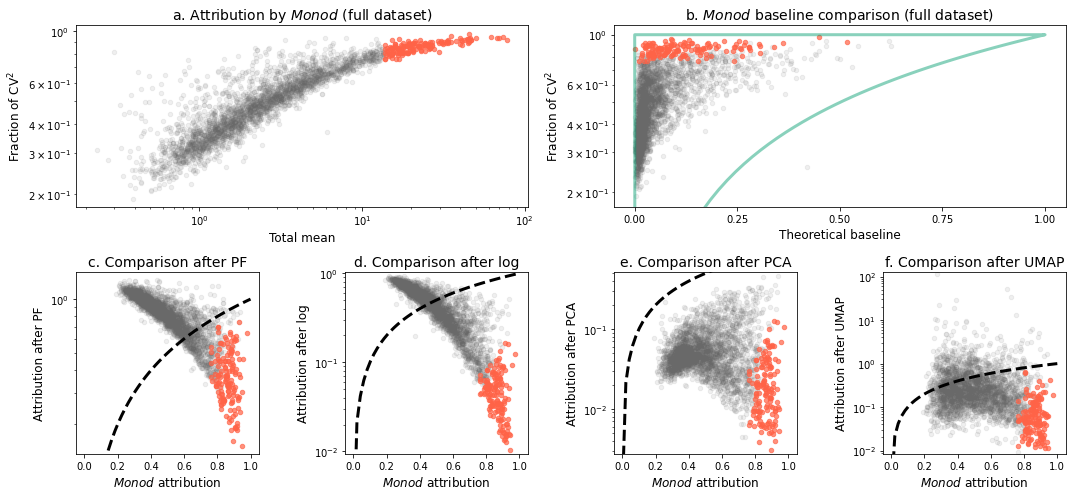

In [94]:
# fig1,ax1=plt.subplots(1,2,figsize=(12,6))
fig1,ax1=plt.subplots(2,4,figsize=(15,7))


gs = ax1[0,0].get_gridspec()
for ax in ax1[0,0:2]:
    ax.remove()
ax1_a = fig1.add_subplot(gs[0,0:2])
ax1_a.scatter(total_mean[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_a.scatter(total_mean[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_a.set_xscale('log')
ax1_a.set_yscale('log')
ax1_a.set_xlabel('Total mean',fontsize=fs_axes)
ax1_a.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
ax1_a.set_title('{}. '.format(chr(97))+r'Attribution by $\it{Monod}$ (full dataset)',fontsize=fs_title)

gs = ax1[0,2].get_gridspec()
for ax in ax1[0,2:]:
    ax.remove()
ax1_b = fig1.add_subplot(gs[0,2:])
ax1_b.scatter(baseline[gf],cv2_monod_frac_glu[gf],ms_genes,c_genes,alpha=alpha_genes)
ax1_b.scatter(baseline[~gf],cv2_monod_frac_glu[~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
ax1_b.set_yscale('log')
ax1_b.set_xlabel('Theoretical baseline',fontsize=fs_axes)
ax1_b.set_ylabel('Fraction of CV$^2$',fontsize=fs_axes)
xmin = 0.001
region_x = np.concatenate((np.linspace(xmin,1),[0,xmin]))
region_y = np.concatenate((np.linspace(xmin,1),[1,xmin]))
ax1_b.plot(region_x,region_y,color=c_baseline,alpha=alpha_line,linewidth=lw)
ax1_b.set_ylim([cv2_monod_frac.min()*0.9,cv2_monod_frac.max()*1.1])
ax1_b.set_xticks(np.linspace(0,1,5))
ax1_b.set_title('{}. '.format(chr(97+1))+r'$\it{Monod}$ baseline comparison (full dataset)',fontsize=fs_title)

names = ['PF','log','PCA','UMAP']
for k in range(4):
    ax1[1,k].scatter(cv2_monod_frac_glu[gf],cv2_fracs[k][gf],ms_genes,c_genes,alpha=alpha_genes)
    ax1[1,k].scatter(cv2_monod_frac_glu[~gf],cv2_fracs[k][~gf],ms_highlight,c_highlight,alpha=alpha_highlight)
    xmin = 0.001
    x_id = np.linspace(xmin,1)
    ax1[1,k].plot(x_id,x_id,'--',color=c_identity,linewidth=lw)
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_yscale('log')
    ax1[1,k].set_ylim([cv2_fracs[k].min()*0.9,cv2_fracs[k].max()*1.1])
    ax1[1,k].set_xlabel(r'$\it{Monod}$ attribution',fontsize=fs_axes)
    ax1[1,k].set_ylabel(r'Attribution after {}'.format(names[k]),fontsize=fs_axes)
    ax1[1,k].set_title('{}. Comparison after {}'.format(chr(97+k+2),names[k]),fontsize=fs_title)

fig1.tight_layout()
fig1.savefig('./figs/monod_glu.png',dpi=450)
fig1.savefig('./figs/monod_glu.pdf')


# Correlations

In [275]:
p.shape

(3, 2951)

In [276]:
c2 = -1

In [277]:
li = sr_arr[-1].samp_optimum_ind

p = 10**sr_arr[c2].param_estimates[li] #b, beta, gamma
l = 10**sr_arr[c2].regressor[li]

p=p.T
l=l.T

In [278]:
dataset_names

['allen_B08_L23IT',
 'allen_B08_L5IT',
 'allen_B08_L6IT',
 'allen_B08_L56NP',
 'allen_B08_L6CT',
 'allen_B08_L6b',
 'allen_B08_Glutamatergic']

In [279]:
sd = monod.analysis.load_search_data(sd_strings[c2])

In [280]:
for x in sr_arr:
    x.set_sampling_optimum(li)

In [281]:
_=sr_arr[c2].chisquare_testing(sd,threshold=0.01)

KeyboardInterrupt: 

In [282]:
sr_arr[c2].rejected_genes.sum()

387

In [283]:
sd.layers.shape

(2, 2951, 5343)

In [284]:
SU_corr_l6 = np.array([np.corrcoef(x,y)[0][1] for x,y in zip(sd.layers[0],sd.layers[1])])


In [285]:
SU_corr_l6.shape

(2951,)

In [286]:
cov_nm_bio = p[0]**2/(p[1]+p[2])
mu_n_bio_glu =  p[0]/p[1]
var_n_bio_glu = mu_n_bio_glu*(1+p[0])
mu_m_bio_glu =  p[0]/p[2]
var_m_bio_glu = mu_m_bio_glu*(1+p[0]*p[1]/(p[1]+p[2]))
corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

In [287]:
corr_nm_bio[sr_arr[c2].rejected_genes]=np.nan

In [288]:
# cov_nm_bio = l[0]*l[1]*p[0]**2/(p[1]+p[2])
# mu_n_bio_glu =  l[0]*p[0]/p[1]
# var_n_bio_glu = mu_n_bio_glu*(1+l[0]*(1+p[0]))
# mu_m_bio_glu =  l[1]*p[0]/p[2]
# var_m_bio_glu = mu_m_bio_glu*(1+l[1]*(1+p[0]*p[1]/(p[1]+p[2])))
# corr_nm_bio = cov_nm_bio/np.sqrt(var_n_bio_glu*var_m_bio_glu)

(array([   3.,    3.,    0.,   27.,   68.,  154.,  482., 1024.,  714.,
          89.]),
 array([0.27884348, 0.34636394, 0.41388441, 0.48140488, 0.54892535,
        0.61644581, 0.68396628, 0.75148675, 0.81900721, 0.88652768,
        0.95404815]),
 <BarContainer object of 10 artists>)

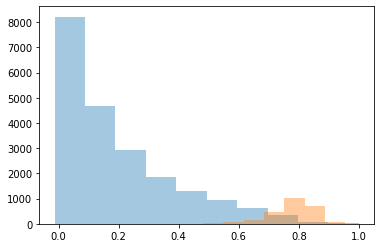

In [289]:
plt.hist(SU_corr,alpha=0.4)
plt.hist(corr_nm_bio,alpha=0.4)

In [290]:
zr = np.log((1+corr_nm_bio)/(1-corr_nm_bio))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
ypos = U_-corr_nm_bio
yneg = corr_nm_bio-L

In [291]:
zr = np.log((1+SU_corr_l6)/(1-SU_corr_l6))/2
L = zr-1.95/np.sqrt(n_cells[c2]-3)
U_ = zr+1.95/np.sqrt(n_cells[c2]-3)

L = (np.exp(2*L)-1)/(np.exp(2*L)+1)
U_ = (np.exp(2*U_)-1)/(np.exp(2*U_)+1)
xpos = U_-SU_corr_l6
xneg = SU_corr_l6-L

In [292]:
(~gf).sum()

148

Text(0, 0.5, 'Predicted biological N/M correlation')

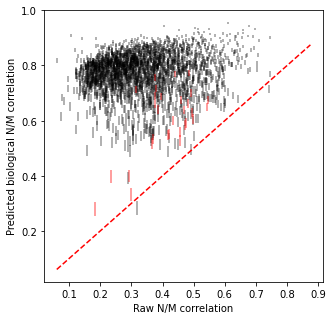

In [293]:
# plt.errorbar(SU_corr_l6,corr_nm_bio,yerr=np.asarray([yneg,ypos]),linestyle='',alpha=0.4,color='k')
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr_l6),max(SU_corr_l6)]
# ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],xerr=np.asarray([xneg[gf],xpos[gf]]),linestyle='',alpha=0.4,color='k')
# ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],xerr=np.asarray([xneg[~gf],xpos[~gf]]),linestyle='',alpha=0.5,color='r')

ax1.errorbar(SU_corr_l6[gf],corr_nm_bio[gf],yerr=np.asarray([yneg[gf],ypos[gf]]),linestyle='',alpha=0.4,color='k')
ax1.errorbar(SU_corr_l6[~gf],corr_nm_bio[~gf],yerr=np.asarray([yneg[~gf],ypos[~gf]]),linestyle='',alpha=0.5,color='r')
ax1.plot(xl,xl,'r--')

ax1.set_xlabel('Raw N/M correlation')
ax1.set_ylabel('Predicted biological N/M correlation')

In [294]:
sd.gene_names[~gf]

array(['Inpp4a', 'Ptprn', 'Itm2c', 'Epha4', 'Atp1b1', 'Lpgat1', 'Psap',
       'Serinc1', 'Zwint', 'Ank3', 'Spock2', 'Actr2', 'Camk2b', 'Hlf',
       'Sptbn1', 'Rbfox3', 'Nsg2', 'Adcy1', 'Gabra1', 'Ddx5', 'Pafah1b1',
       'Nsf', 'Prkar1a', 'Rtn4', 'Ywhae', 'Cyfip2', 'Mapt', 'Rock2',
       'Myt1l', 'Rtn1', 'Vsnl1', 'Rian', 'Mef2c', 'Cplx2', 'Rgs7bp',
       'Map1b', 'Ntrk2', 'Smim13', 'Ppp3cb', 'Dpysl2', 'Fzd3', 'Mycbp2',
       'Cntn1', 'Ywhaz', 'Arf3', 'Basp1', 'Scn8a', 'Ncald', 'App',
       'Gsk3b', 'Atp6v1a', 'Mapk1', 'Cd47', 'Ttc3', 'Synj1', 'Pja2',
       'Ptprs', 'Slc8a1', 'Prkce', 'Celf4', 'Impact', 'Ndfip1', 'Camk2a',
       'Pura', 'Tcf4', 'Pten', 'Gnaq', 'Rtn3', 'Klf9', 'Gda', 'Ywhab',
       'Kif5c', 'Olfm1', 'Scn2a', 'Nckap1', 'Napb', 'Stxbp1', 'Fam171b',
       'Kcnb1', 'Ndrg3', 'Chn1', 'Dnajc5', 'Dnm1', 'Slc12a5', 'Rasgrp1',
       'Stmn3', 'Prkacb', 'Stmn2', 'Sec62', 'Rap1gds1', 'Atp1a1', 'Ank2',
       'Dclk1', 'Plppr4', 'Gria2', 'Syt11', 'Hpca', 'Kif1b', 'Gnb1',
  

In [295]:
gf_violat = corr_nm_bio<SU_corr_l6

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([  5.47016863,   8.74701148,  12.02385433,  15.30069717,
         18.57754002,  21.85438286,  25.13122571,  28.40806855,
         31.6849114 ,  34.96175424,  38.23859709,  41.51543993,
         44.79228278,  48.06912562,  51.34596847,  54.62281132,
         57.89965416,  61.17649701,  64.45333985,  67.7301827 ,
         71.00702554,  74.28386839,  77.56071123,  80.83755408,
         84.11439692,  87.39123977,  90.66808261,  93.94492546,
         97.22176831, 100.49861115, 103.775454  ]),
 <BarContainer object of 30 artists>)

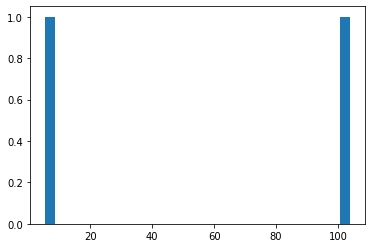

In [296]:
plt.hist(p[0,gf_violat],30)

In [297]:
((~gf)&gf_violat).sum()

0

In [298]:
(corr_nm_bio<SU_corr_l6).sum()

2

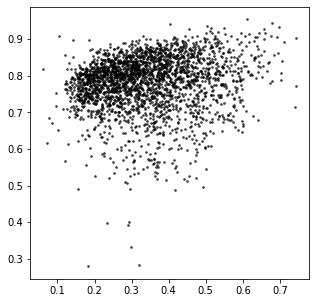

In [299]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6,corr_nm_bio,3,'k',alpha=0.6)
ax1.plot(xl,xl,'r--')


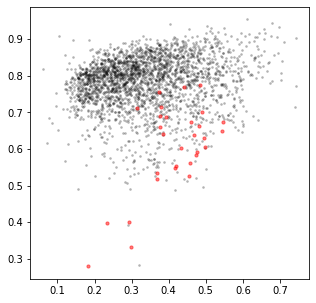

In [300]:
fig1,ax1 = plt.subplots(1,1,figsize=(5,5))

xl = [min(SU_corr),max(SU_corr)]
ax1.scatter(SU_corr_l6[gf],corr_nm_bio[gf],3,'k',alpha=0.2)
ax1.scatter(SU_corr_l6[~gf],corr_nm_bio[~gf],10,'r',alpha=0.5)
ax1.plot(xl,xl,'r--')


In [304]:
len(SU_corr_l6)

2951

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32285 but corresponding boolean dimension is 2951

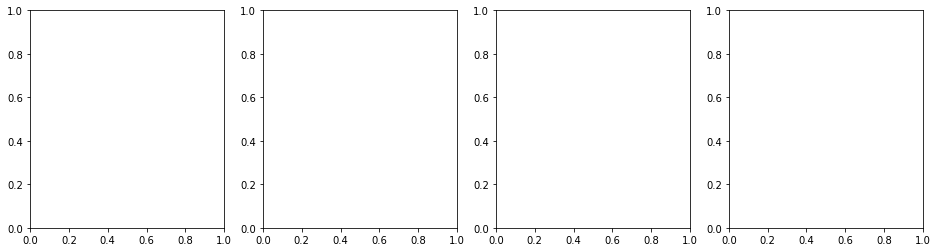

In [301]:
fig1,ax1 = plt.subplots(1,4,figsize=(16,4))

xl = [min(SU_corr),max(SU_corr)]
ax1[0].scatter(SU_corr[gf],SU_corr_PF[gf],3,'k',alpha=0.2)
ax1[0].scatter(SU_corr[~gf],SU_corr_PF[~gf],10,'r',alpha=0.5)
ax1[0].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[1].scatter(SU_corr[gf],SU_corr_log[gf],3,'k',alpha=0.2)
ax1[1].scatter(SU_corr[~gf],SU_corr_log[~gf],10,'r',alpha=0.5)
ax1[1].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[2].scatter(SU_corr[gf],SU_corr_PCA[gf],3,'k',alpha=0.2)
ax1[2].scatter(SU_corr[~gf],SU_corr_PCA[~gf],10,'r',alpha=0.5)
ax1[2].plot(xl,xl,'r--')

xl = [min(SU_corr),max(SU_corr)]
ax1[3].scatter(SU_corr[gf],SU_corr_UMAP[gf],3,'k',alpha=0.2)
ax1[3].scatter(SU_corr[~gf],SU_corr_UMAP[~gf],10,'r',alpha=0.5)
ax1[3].plot(xl,xl,'r--')
for i,ax in enumerate(ax1):
    ax.set_title(steps[i+1])
    ax.set_xlabel('nas/mat corr (raw)')
    ax.set_ylabel('nas/mat corr after step')
fig1.tight_layout()

In [622]:
SU_corr_PCA.shape

(1475,)